In [91]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm # 
import torch
from photontorch import photontorch as pt

Define the refractive index values for different components

In [128]:
# define the simulation environment:
env = pt.Environment(
    wavelength = 1e-6 * np.linspace(1.550, 1.560, 100000),  # [m]
    freqdomain = True,  # We will be doing frequency domain simulations
)

# set the global simulation environment:
pt.set_environment(env)

# one can always get the current environment from photontorch:
pt.current_environment()

key,value,description
name,env,name of the environment
t,0.000e+00,[s] full 1D time array.
t0,0.000e+00,[s] starting time of the simulation.
t1,None,[s] ending time of the simulation.
num_t,1,number of timesteps in the simulation.
dt,None,[s] timestep of the simulation
samplerate,None,[1/s] samplerate of the simulation.
bitrate,None,[1/s] bitrate of the signal.
bitlength,None,[s] bitlength of the signal.
wl,"[1.550e-06, 1.550e-06, ..., 1.560e-06]",[m] full 1D wavelength array.


In [129]:
import pandas as pd

parameters = pd.DataFrame(
    data={
        "n": [2.36372, 1.88581, 1.62927],
        "neff": [1.7732, 1.5946, 1.5166],
        "wl0": [1550, 1550, 1550],  # [nm]
        "width": [700, 1400, 2200],  # [nm]
        "thickness": [390, 500, 1000],  # [nm]
        "dg": [500, 500, 200],  # [nm]
        "mewd": [716, 855, 860],  # [nm]
        "FSR": [3.56, 0.22188, 0.8310],  # [nm]
        "lambda": [1553.68, 1554.4, 1553.48],  # [nm]
    },
    index=["TiO2", "ZnO", "Al2O3"],
)
parameters

,n,neff,wl0,width,thickness,dg,mewd,FSR,lambda
TiO2,2.36372,1.7732,1550,700,390,500,716,3.56000,1553.68
ZnO,1.88581,1.5946,1550,1400,500,500,855,0.22188,1554.40
Al2O3,1.62927,1.5166,1550,2200,1000,200,860,0.83100,1553.48


In [170]:
ring_radius = 120e-6
ring_length = 2 * np.pi * ring_radius
group_index = parameters['neff']['ZnO']  #(parameters['lambda']['ZnO'] * 1e-9) ** 2 / (ring_length * parameters['FSR']['ZnO'])

ring_component = pt.Waveguide(
    length=ring_length,
    loss=0.02e-3,
    neff=parameters['neff']['ZnO'],
    wl0=parameters['wl0']['ZnO'] * 1e-9,
    ng=group_index,
    phase=0,
    trainable=True
)

coupler_component = pt.DirectionalCouplerWithLength(
    length=2 * ring_radius + parameters['width']['ZnO'],
    loss=0.02e-3,
    coupling=0.01,
    neff=parameters['neff']['ZnO'],
    wl0=parameters['wl0']['ZnO'] * 1e-9,
    ng=group_index,
    phase=0,
    trainable_phase=True,
)

In [171]:
class AllPassRingResonator(pt.Network):
    def __init__(self, coupler, ring, name=None):
        super(AllPassRingResonator, self).__init__(name=name)  # always initialize parent first

        # define subcomponents
        self.source = pt.Source()
        self.detector = pt.Detector()
        self.dc = coupler
        self.ring = ring
        self.link('source:0', '0:dc:2', '0:ring:1', '3:dc:1', '0:detector')

In [172]:
device = AllPassRingResonator(coupler=coupler_component, ring=ring_component)
detected = device(source=1)
print(detected.shape)

torch.Size([1, 100000, 1, 1])


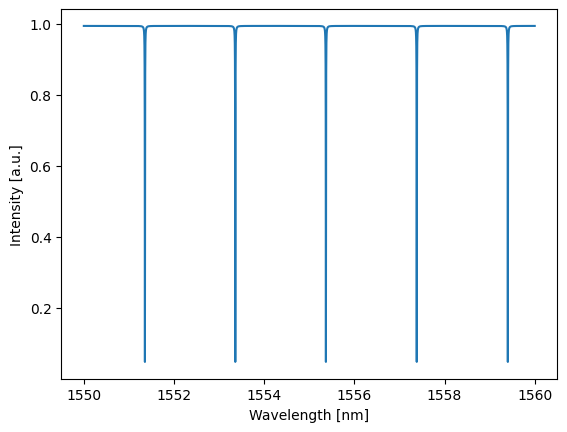

In [173]:
device.plot(detected)
# plt.xlim([1554, 1557])
plt.show()